### 0. Importing relevant modules

In [28]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
# torchvision.datasets module contains `Dataset` objects for many real-world vision data
from torchvision import datasets # other domain-specific libraries TorchAudio, TorchText
from torchvision.transforms import (
    ToTensor, # for normalizing the pixel values to the range [0,1]
    Lambda, # to make user-defined functions as one of the transformations 
    Compose # can stitch together transforms
    )
import matplotlib.pyplot as plt

In [26]:
import numpy as np

### 1A. Converting Data into Model Suitable Iterables 

- Downloading and transforming the datasets
- Preparing train, validation and test datasets

In [ ]:
# help(datasets.FashionMNIST)
help(datasets.MNIST)

In [38]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [21]:
print(test_data.test_labels[0:5])
print(len(test_data.test_labels[0:5]))

tensor([9, 2, 1, 1, 6])
5


In [16]:
training_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

```python
# If you have a custom dataset in your location

class CustomImageDataset(Dataset):
    """FashionMNIST like Image Dataset Class"""
    def __init__(self, 
                 annotations_file,
                 img_dir,
                 transform=None,
                 target_transform=None):
        """
        Args:
            transform (Optional): dataset will take an optional argument transform 
                so that any required processing can be applied on the sample
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        # format of data 
        # image_location, label_type
        # tshirt1.jpg, T-shirt/top # class needs to be convered into numerical format
        # pant4.jpg, Trouser # class needs to be convered into numerical format
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = tvio.read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return sample


# target_transform
# turn the integer y values into a `one_hot_encoded` vector 
# 1. create a zero tensor of size 10 torch.zeros(10, dtype=torch.float)
# 2. `scatter_` assigns a value =1
the_target_lambda_function = Lambda(lambda y: torch.zeros(10,
                                    dtype=troch.float).scatter_(dim=0,
                                                    index=torch.tensor(y), value=1))


training_data = CustomImageDataset(
    root="data", # the path where the train/test data is stored
    train=True, # False if it is a test dataset 
    download=False, # downloads the data from Web if not available at root
    transform=ToTensor(), # transform the features; converts PIL image or numpy array into a FloatTensor and scaled the image's pixel intensity to the range [0,1]
    target_transform=the_target_lambda_function
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
    target_transform=the_target_lambda_function
    # target_transform=torch.nn.functional.one_hot(y, num_classes=10) # alternate way
)
```

Preparing Validation Data from Test Data

In [39]:
indices = list(range(len(training_data)))
np.random.shuffle(indices)

print(indices[0:5])

[53982, 49812, 50909, 30514, 9162]


In [40]:
split = int(np.floor(0.2 * len(training_data)))
training_data_sample = SubsetRandomSampler(indices[split:])
validation_data_sample = SubsetRandomSampler(indices[:split])

Convert into iterables

In [41]:
batchsize = 64

# create iterables 
train_dataloader = DataLoader(training_data, sampler=training_data_sample, batch_size=batchsize)
validation_dataloader = DataLoader(training_data, sampler=validation_data_sample, batch_size=batchsize)
test_dataloader = DataLoader(test_data, batch_size=batchsize)

print(len(train_dataloader))
print(len(validation_dataloader))
print(len(test_dataloader))

# to understand the shape of input features and output
for X,y in test_dataloader:
    print("Shape of Features:",X.shape)
    print("Shape of Labels:",y.shape)
    break

750
188
157
Shape of Features: torch.Size([64, 1, 28, 28])
Shape of Labels: torch.Size([64])


- The above shape of training image is in the format NCHW
- batchsize N, no. of channels C, height H, width W

### 1B. Visualize sample data

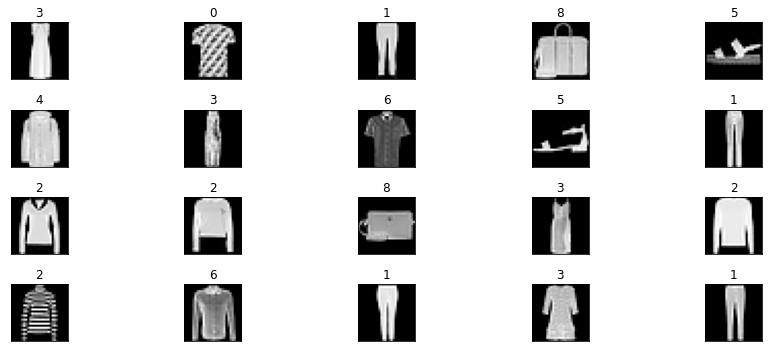

In [43]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(15,5))

for idx in np.arange(20):
    ax = fig.add_subplot(4, int(20/4), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(labels[idx].item())
    fig.tight_layout()

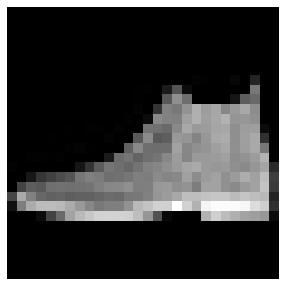

In [47]:
# looking into just one image, label

figure = plt.figure(figsize=(5,5))
img, label = test_data[0]

plt.axis("off")
plt.imshow(img.squeeze(),cmap="gray")

## 2. Build the Model Layers

Build a NN with **2 hidden layers** and 1 output layer

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [50]:
# defining the model architecture

class NeuralNetwork(nn.Module):
    def __init__(self):
        # initialize the layers in __init__ constructor
        super(NeuralNetwork,self).__init__()
        # supercharge your sub-class by inheriting the defaults from Parent class
        self.flatten = nn.Flatten()
        # one can also use Functional API in PyTorch 
        # but below codes use Sequential API
        # the below stack of layers generates scores or logits
        self.linear_relu_stack = nn.Sequential(
            # hidden layer 1 consisting of 512 neurons
            nn.Linear(28*28, 512),
            nn.ReLU(),
            # hidden layer 2 consisting of 512 neurons too
            nn.Linear(512,512),
            nn.ReLU(),
            # output layer consisting of 10 neurons 
            nn.Linear(512,10),
            # we can also build a NN without this final layer ReLU
            # instead can also run the log_softmax directly
            nn.ReLU(), 
        )
        
    def forward(self,x): # need to pass the input argument x
        # function where the input is run through 
        # the initialized layers
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
# create a instance of the class NeuralNetwork 
# move it to the device (CPU or GPU)
model = NeuralNetwork().to(device)

# print model structure
print(model)

# is nn.ReLU in the final layer?
# https://ai.stackexchange.com/questions/8491/does-it-make-sense-to-apply-softmax-on-top-of-relu

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


- Why `model(X)` instead of `model.forward(X)`? <br>
[Source](https://stackoverflow.com/questions/55338756/why-there-are-different-output-between-model-forwardinput-and-modelinput) 

Dissecting the steps using Functional API

- **Step 1**:Convert `28*28` into a contiguous array of 784 pixel values
    
```python
input_image = torch.rand(3, 28, 28)
print(input_image.size())
# step 1: Flatten the input image
flatten = nn.Flatten() # instantitate
flat_image = flatten(input_image)  # pass the prev layer (input) into the instance
print(flat_image.size())
```
- **Step 2**: Dense or linear layer in PyTorch `weight * input + bias`
    
```python    
# step 2: apply linear transformation `weight * input + bias`
layer1 = nn.Linear(in_features=28*28, out_features=512) # instantiate
hidden1 = layer1(flat_image) # pass the prev layer (flattened image) into the instance
print(hidden1.size())
```

- **Step 3**: Apply Relu activation on the linear transformation
    
```python
relu_activation = nn.ReLU() #instantiate
hidden1 = relu_activation(hidden1)
```    
Repeat Step 2 and 3 for `hidden2`: <br>

```python
layer2 = nn.Linear(in_features=512, out_features=512)
hidden2 = layer2(hidden1)
hidden2 = relu_activation(hidden2)
```    
    
- **Step 4**: Compute the logits
    
```python
# a simple 1 hidden layer NN with 20 neurons in the hidden layer
nn_seq_modules = nn.Sequential(
                    flatten,
                    layer1,
                    relu_activation,
                    layer2,
                    relu_activation,
                    nn.Linear(512, 10), # the output                )
input_image = torch.rand(3, 28, 28)
logits =  nn_seq_modules(input_image)   
```
    
- **Step 5**: Apply `Softmax` function
    
```python

softmax = nn.Softmax(dim=1)
predict_probab = softmax(logits)

```


### 3. Training the Model 
Training with training data and evaluating loss on Validation Data

#### 3A.Setting Hyperparameters

- `num_of_epochs`: The number of times the entire training dataset is pass through the network
- `batch_size`: The number of data samples seen by the model before updating its weights. (derived parameter `steps = total_training_data/batch_size` - the number of batches needed to complete an epoch)
- `learning_rate`: How much to change the weights in the `w = w - learning_rate * gradient`. Smaller value means the model will take a longer time to find best weights. Larger value of learning_rate might make the NN miss the optimal weights because we might step over the best values
- Choice of `loss_fn`
Common Loss Functions:    
    - nn.MSELoss # Mean Squared Error
    - nn.NLLLoss #Negative Log Likelihood    
    - nn.CrossEntropyLoss # = combine(`nn.LogSoftmax` and `nn.NLLLoss`)   

- Choice of `optimizer`

In [74]:
num_of_epochs = 40
batchsize = 64 # already mentioned in the DataLoader arguments
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate
                           )
# SGD optimizer in PyTorch actually is Mini-batch Gradient Descent with momentum
# it updates one mini-batch at a time (batchsize)
# Source: https://discuss.pytorch.org/t/how-sgd-works-in-pytorch/8060

#### 3B. Writing Core Training and Evaluation Loop Functions

- `loss_fn` and `optimizer` are passed to `train_loop` and just `loss_fn` to `test_loop`
```python
for i in range(epochs):
    print(f"Epoch {i+1}\n ----------------------------")
    train_loop(train_dataloader, validation_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader,model, loss_fn)
print("Over!")    
```

In [75]:
def train_loop(train_dataloader, validation_dataloader, model, loss_fn, optimizer):
    train_size = len(train_dataloader.dataset)
    validation_size = len(validation_dataloader.dataset)
    training_loss_per_epoch = 0
    validation_loss_per_epoch = 0
    for batch_number, (X,y) in enumerate(train_dataloader):
        X,y = X.to(device), y.to(device)
        
        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation steps
        # key optimizer steps
        # by default, gradients add up in PyTorch
        # we zero out in every iteration
        optimizer.zero_grad() 
        # performs the gradient computation steps (across the DAG)
        loss.backward()
        # adjust the weights
        optimizer.step()
        training_loss_per_epoch += loss.item()
        
#         if batch_number % 100 == 0:
#             print(f"After completing {batch_number * len(X)} samples, the loss is:")
#             print(loss.item()) 
            
    for batch_number, (X,y) in enumerate(validation_dataloader):
        X,y = X.to(device), y.to(device)
        
        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        validation_loss_per_epoch += loss.item()
        
    print(f"Average Training Loss: {training_loss_per_epoch/train_size}")
    print(f"Average Validation Loss: {validation_loss_per_epoch/validation_size}")

In [77]:
def test_loop(test_dataloader,model, loss_fn):
    test_size = len(test_dataloader.dataset)
    # Failing to do eval can yield inconsistent inference results
    model.eval()
    test_loss_per_epoch, accuracy_per_epoch = 0, 0
    # disabling gradient tracking while inference
    with torch.no_grad():
        for X,y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss_per_epoch += loss.item()
            accuracy_per_epoch += (pred.argmax(1)==y).type(torch.float).sum().item()
    print(f"Average Test Loss: {test_loss_per_epoch/test_size}")
    print(f"Average Accuracy: {accuracy_per_epoch/test_size}")

### 3C. Training the model now with all the above datasets, fns and hyperparameters


In [78]:
%%time
for epoch in range(num_of_epochs):
    print(f"Epoch Number: {epoch} \n---------------------")
    train_loop(train_dataloader, validation_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader,model, loss_fn)

Epoch Number: 0 
---------------------
Average Training Loss: 0.0165973157842954
Average Validation Loss: 0.0041493269463380176
Average Test Loss: 0.02104052450656891
Average Accuracy: 0.5987
Epoch Number: 1 
---------------------
Average Training Loss: 0.01646539914906025
Average Validation Loss: 0.004115968574086825
Average Test Loss: 0.020881393748521805
Average Accuracy: 0.6008
Epoch Number: 2 
---------------------
Average Training Loss: 0.016331461442510287
Average Validation Loss: 0.004083967661857605
Average Test Loss: 0.020714229398965837
Average Accuracy: 0.6027
Epoch Number: 3 
---------------------
Average Training Loss: 0.01620158564547698
Average Validation Loss: 0.0040510257869958875
Average Test Loss: 0.020553202044963838
Average Accuracy: 0.6054
Epoch Number: 4 
---------------------
Average Training Loss: 0.016072398351629574
Average Validation Loss: 0.004019714547197024
Average Test Loss: 0.020403052824735642
Average Accuracy: 0.6061
Epoch Number: 5 
----------------

Points to ponder: 
- The accuracy for this 2-layer NN stands at 64%. 
- Probably deepening the number of hidden layers can help in improving the accuracy or changing the architecture to use CNN or any pre-trained NN will improve further

### 3D. Saving the model

In [79]:
!mkdir -p model_weights/

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.utf-8)


In [80]:
torch.save(model.state_dict(),"model_weights/fmnist_2_layer_nn_model.pth")

### 4. Predict using the Trained Model
Loading the trained model and predicting for unseen data

In [81]:
# construct the model structure
model = NeuralNetwork()
# load the state_dict
model.load_state_dict(torch.load("model_weights/fmnist_2_layer_nn_model.pth"))

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


TODO

### 5. Visualize the Model Training
- How to visualize the training in Tensorboard

Sources: <br>
- MSFT PyTorch Course | [link](https://docs.microsoft.com/en-us/learn/modules/intro-machine-learning-pytorch/8-quickstart)
- PyTorch Official Tutorial Explaining with FashionMNIST data | [link](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html)
- A useful Medium article on FashionMNIST dataset | [link](https://medium.com/@aaysbt/fashion-mnist-data-training-using-pytorch-7f6ad71e96f4)